In [1]:
!git clone https://github.com/SKfaizan-786/EAST-text-detection.git
%cd EAST-text-detection

Cloning into 'EAST-text-detection'...
remote: Enumerating objects: 3018, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3018 (delta 0), reused 3 (delta 0), pack-reused 3014 (from 1)
Receiving objects: 100% (3018/3018), 129.11 MiB | 23.87 MiB/s, done.
/content/EAST-text-detection


In [ ]:
# !pip install -r requirements.txt

In [3]:
import os
import cv2
import numpy as np
from shapely.geometry import Polygon
from shapely.affinity import scale
import matplotlib.pyplot as plt
from glob import glob

# Base paths inside the cloned repo
DATA_DIR = "data/icdar2015"
TRAIN_IMG_DIR = f"{DATA_DIR}/train_images"
TRAIN_LABEL_DIR = f"{DATA_DIR}/train_labels"
TRAIN_MAP_DIR = f"{DATA_DIR}/train_maps"
os.makedirs(TRAIN_MAP_DIR, exist_ok=True)

TEST_IMG_DIR = f"{DATA_DIR}/test_images"
TEST_LABEL_DIR = f"{DATA_DIR}/test_labels"
TEST_MAP_DIR = f"{DATA_DIR}/test_maps"
os.makedirs(TEST_MAP_DIR, exist_ok=True)

print("Train images:", len(glob(f"{TRAIN_IMG_DIR}/*.jpg")))
print("Train labels:", len(glob(f"{TRAIN_LABEL_DIR}/*.txt")))

Train images: 1000
Train labels: 1000


In [4]:
def parse_label_file(label_path):
    """
    Parses an ICDAR2015 label txt file and returns a list of quads.
    Each quad is [(x1,y1),(x2,y2),(x3,y3),(x4,y4)].
    """
    quads = []
    with open(label_path, "r", encoding="utf-8-sig") as f:
        for line in f.readlines():
            parts = line.strip().split(',')
            if len(parts) >= 8:
                coords = list(map(float, parts[:8]))
                quad = [(coords[i], coords[i+1]) for i in range(0, 8, 2)]
                quads.append(quad)
    return quads

def shrink_quad(quad, ratio=0.3):
    """
    Shrink quadrilateral inward using shapely.
    ratio ~0.3 recommended in EAST paper.
    """
    poly = Polygon(quad)
    if not poly.is_valid:
        return poly
    # shrink uniformly around center
    return scale(poly, xfact=1-ratio, yfact=1-ratio, origin='centroid')

In [6]:
def generate_maps(img, quads, shrink_ratio=0.3):
    H, W = img.shape[:2]
    score_map = np.zeros((H, W), dtype=np.uint8)
    geo_map   = np.zeros((H, W, 8), dtype=np.float32)

    for quad in quads:
        shrunk = shrink_quad(quad, shrink_ratio)
        if shrunk.is_empty:
            continue

        # fill positive area
        mask = np.zeros((H, W), dtype=np.uint8)
        pts = np.array(list(shrunk.exterior.coords)[:-1], dtype=np.int32)
        cv2.fillPoly(mask, [pts], 1)
        ys, xs = np.where(mask == 1)
        score_map[ys, xs] = 1

        # geometry offsets
        quad_arr = np.array(quad, dtype=np.float32)
        for y, x in zip(ys, xs):
            for k in range(4):
                dx = quad_arr[k,0] - x
                dy = quad_arr[k,1] - y
                geo_map[y,x,2*k]   = dx
                geo_map[y,x,2*k+1] = dy

    return score_map, geo_map

In [7]:
sample_imgs = sorted(glob(f"{TRAIN_IMG_DIR}/*.jpg"))[:5]
for img_path in sample_imgs:
    name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(TRAIN_LABEL_DIR, f"gt_{name}.txt")
    img = cv2.imread(img_path)
    quads = parse_label_file(label_path)
    score_map, geo_map = generate_maps(img, quads)

    np.save(os.path.join(TRAIN_MAP_DIR, f"{name}_score.npy"), score_map)
    np.save(os.path.join(TRAIN_MAP_DIR, f"{name}_geo.npy"), geo_map)

print("✅ Saved 5 sample maps to train_maps/")

✅ Saved 5 sample maps to train_maps/


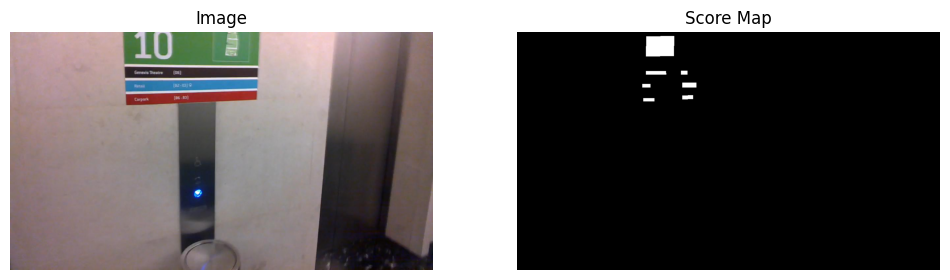

In [8]:
# visualize one example
idx = 0
img = cv2.imread(sample_imgs[idx])[:,:,::-1]  # BGR->RGB
name = os.path.splitext(os.path.basename(sample_imgs[idx]))[0]
score_map = np.load(os.path.join(TRAIN_MAP_DIR, f"{name}_score.npy"))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(score_map, cmap="gray"); plt.title("Score Map"); plt.axis("off")
plt.show()

In [9]:
def process_split(img_dir, label_dir, out_dir):
    img_paths = sorted(glob(f"{img_dir}/*.jpg"))
    for img_path in img_paths:
        name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, f"gt_{name}.txt")
        if not os.path.exists(label_path):
            continue
        img = cv2.imread(img_path)
        quads = parse_label_file(label_path)
        score_map, geo_map = generate_maps(img, quads)
        np.save(os.path.join(out_dir, f"{name}_score.npy"), score_map)
        np.save(os.path.join(out_dir, f"{name}_geo.npy"), geo_map)

# Process training and test sets
process_split(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, TRAIN_MAP_DIR)
process_split(TEST_IMG_DIR, TEST_LABEL_DIR, TEST_MAP_DIR)
print("✅ Finished generating score & geometry maps for all images.")

✅ Finished generating score & geometry maps for all images.
